# Census (July 2019–January 2020)
Natalia Vélez, January 2020

In this notebook:
* How much activity was there in each server? in each release?
* Aggregate measures: Age and cause of death
* How stable are these aggregate measures over different releases?

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

## Prepare data for analysis

Load all data:

In [2]:
lifelog_data = pd.read_csv('outputs/lifelogs_201907-202005_data.tsv', sep='\t')
lifelog_data.head()

,Unnamed: 0,release,server,event,timestamp,playerID,hash,uniqueID,age,sex,location,parent,cause_of_death,killer,pop,chain
0,0,254.0,bigserver2,D,1564444828,1842380,583a6de73718f5dd0ddf388f4e68dc060b15e6df,1842380_bigserver2_254.0,1.81,F,"(48, 94)",NaN,hunger,NaN,82,NaN
1,1,254.0,bigserver2,D,1564444830,1842301,520ddb069aa77dcb202dd0310a8852e8fddc58dd,1842301_bigserver2_254.0,8.00,M,"(40, 350)",NaN,hunger,NaN,82,NaN
2,2,254.0,bigserver2,B,1564444832,1842398,583a6de73718f5dd0ddf388f4e68dc060b15e6df,1842398_bigserver2_254.0,NaN,F,"(-325, 209)",1842145.0,NaN,NaN,84,3.0
3,3,254.0,bigserver2,B,1564444836,1842399,520ddb069aa77dcb202dd0310a8852e8fddc58dd,1842399_bigserver2_254.0,NaN,M,"(67, -266)",1842397.0,NaN,NaN,83,2.0
4,4,254.0,bigserver2,D,1564444859,1842311,dfd85ac03c4dd577352484b023d19d521b592696,1842311_bigserver2_254.0,7.76,M,"(-200, -123)",NaN,hunger,NaN,82,NaN


### Big Server Data only
The bigserver is the only server that records all the data we are interested in for our analyses (lifelogs, map change, etc.), so we will just look at that separately throughout this notebook.

In [3]:
big_df = lifelog_data[lifelog_data['server'] == 'bigserver2'].reset_index(drop=True)
big_df.head()

,Unnamed: 0,release,server,event,timestamp,playerID,hash,uniqueID,age,sex,location,parent,cause_of_death,killer,pop,chain
0,0,254.0,bigserver2,D,1564444828,1842380,583a6de73718f5dd0ddf388f4e68dc060b15e6df,1842380_bigserver2_254.0,1.81,F,"(48, 94)",NaN,hunger,NaN,82,NaN
1,1,254.0,bigserver2,D,1564444830,1842301,520ddb069aa77dcb202dd0310a8852e8fddc58dd,1842301_bigserver2_254.0,8.00,M,"(40, 350)",NaN,hunger,NaN,82,NaN
2,2,254.0,bigserver2,B,1564444832,1842398,583a6de73718f5dd0ddf388f4e68dc060b15e6df,1842398_bigserver2_254.0,NaN,F,"(-325, 209)",1842145.0,NaN,NaN,84,3.0
3,3,254.0,bigserver2,B,1564444836,1842399,520ddb069aa77dcb202dd0310a8852e8fddc58dd,1842399_bigserver2_254.0,NaN,M,"(67, -266)",1842397.0,NaN,NaN,83,2.0
4,4,254.0,bigserver2,D,1564444859,1842311,dfd85ac03c4dd577352484b023d19d521b592696,1842311_bigserver2_254.0,7.76,M,"(-200, -123)",NaN,hunger,NaN,82,NaN


## How many players/lives are in the dataset?

### Birth/death events

Births/deaths by release:

In [4]:
big_activity = big_df.groupby(['release', 'event']).agg({'playerID': 'count'})
big_activity = big_activity.reset_index()

big_activity.head()

,release,event,playerID
0,254.0,B,14297
1,254.0,D,14304
2,255.0,B,12609
3,255.0,D,12595
4,257.0,B,6330


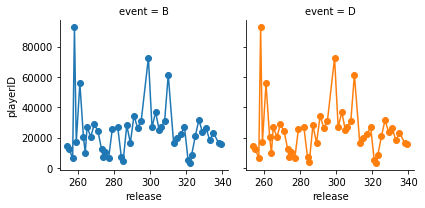

In [5]:
grid = sns.FacetGrid(big_activity, col="event", hue="event")
grid.map(plt.plot, "release", "playerID", marker="o")

Total births and deaths:

In [6]:
big_activity.groupby('event')['playerID'].sum()

event
B    1123282
D    1121830
Name: playerID, dtype: int64

Overall, there are fewer deaths in the data than there are births. Is this because the data for the last release before we initiated the download was incomplete, or because the data are consistently cut off at each release? 


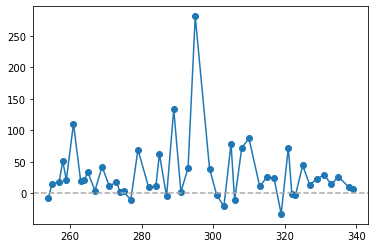

In [7]:
big_by_release = big_activity.groupby(['release', 'event'])['playerID'].sum().reset_index()
big_diff = big_by_release.pivot(index='release', columns='event', values='playerID').reset_index()
big_diff['diff'] = big_diff['B'] - big_diff['D']

plt.plot(big_diff['release'], big_diff['diff'], marker = 'o')
plt.axhline(y = 0, linestyle = '--', color='#aaaaaa')

### Unique player hashes

Each player has a unique, anonymized hash associated with them. By tracking how often a particular hash appears in birth events, we can get a sense of how many "lives" unique players contribute to the dataset. I am also particularly curious about whether there might be some particularly prolific "power-users" driving innovation and development.

Filter birth events:

In [8]:
big_births = big_df[big_df['event'] == 'B'].reset_index(drop=True)
big_births.head()

,Unnamed: 0,release,server,event,timestamp,playerID,hash,uniqueID,age,sex,location,parent,cause_of_death,killer,pop,chain
0,2,254.0,bigserver2,B,1564444832,1842398,583a6de73718f5dd0ddf388f4e68dc060b15e6df,1842398_bigserver2_254.0,NaN,F,"(-325, 209)",1842145.0,NaN,NaN,84,3.0
1,3,254.0,bigserver2,B,1564444836,1842399,520ddb069aa77dcb202dd0310a8852e8fddc58dd,1842399_bigserver2_254.0,NaN,M,"(67, -266)",1842397.0,NaN,NaN,83,2.0
2,8,254.0,bigserver2,B,1564444863,1842400,dfd85ac03c4dd577352484b023d19d521b592696,1842400_bigserver2_254.0,NaN,M,"(16, -57)",1842304.0,NaN,NaN,84,2.0
3,9,254.0,bigserver2,B,1564444864,1842401,fd6e14532b361175d5203c50a22d20fe951c89f0,1842401_bigserver2_254.0,NaN,M,"(146, 49)",1842336.0,NaN,NaN,84,2.0
4,11,254.0,bigserver2,B,1564444866,1842402,f766576701306189b31a049054c0840b39f84c51,1842402_bigserver2_254.0,NaN,F,"(68, 64)",1842334.0,NaN,NaN,84,2.0


Count occurrences of each hash:

In [9]:
big_hash = big_births.groupby('hash')['timestamp'].count().reset_index()
big_hash = big_hash.rename(columns={"hash": "player", "timestamp": "n_lives"})
big_hash.head()

,player,n_lives
0,0002e5ea5ce7cfd761135d255a245a3344af4377,337
1,00047b60a01d908e2407b05a09b404c2f6cec6f6,4
2,0004f2a9005cf3562482fe408876808498e1fad5,11
3,000548ed7f04e2ddf81b4016d87d53ddbbd2e89f,45
4,0005eb266ff93d00bb6072d9c07f3a47d4864219,2


How many unique players are there?

In [10]:
big_hash.shape[0]

28269

How many lives does each player contribute?

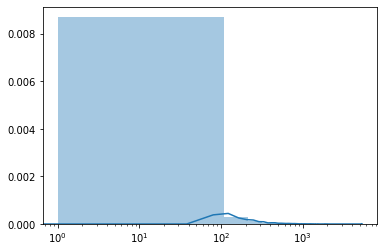

In [11]:
n_lives = big_hash['n_lives'].values
g = sns.distplot(n_lives)
g.set_xscale('log')

Some descriptive statistics:

In [12]:
print('Max: %f' % np.max(n_lives))
print('Min: %f' % np.min(n_lives))
print('Median: %f' % np.median(n_lives))
print(stats.mode(n_lives))

Max: 5343.000000
Min: 1.000000
Median: 5.000000
ModeResult(mode=array([1]), count=array([5716]))


Empirical CDF:

Text(0, 0.5, 'Cumulative density')

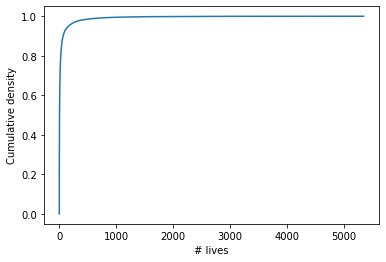

In [13]:
n_lives_ecdf = ECDF(n_lives)
plt.plot(n_lives_ecdf.x, n_lives_ecdf.y)
plt.xlabel('# lives')
plt.ylabel('Cumulative density')

Cumulative counts:

In [14]:
lives_breaks = [1, 25, 50, 100, 500, 1000, 2500, 4000]
lives_prop = n_lives_ecdf(lives_breaks)

lives_list = list(zip(lives_breaks, lives_prop))
print(*['p <= %i: %0.3f' % (l[0], l[1]) for l in lives_list], sep='\n')

p <= 1: 0.202
p <= 25: 0.793
p <= 50: 0.874
p <= 100: 0.926
p <= 500: 0.986
p <= 1000: 0.995
p <= 2500: 0.999
p <= 4000: 1.000


Top contributors:

In [15]:
big_top = big_hash.sort_values('n_lives', ascending=False).reset_index(drop=True)
big_top.to_csv('outputs/topplayers_201907.tsv', sep='\t', index=True)
big_top[:100]

,player,n_lives
0,8ac173f9346f99eff5fb54d55b57acaace951896,5343
1,54a14bbedd0aa108fc4d36923687a81502a92aac,5335
2,71f0317c349c25ec4188f1b501d05bd99d54b505,5196
3,ea5ea8d1bef19a9847bc8ca874e2dfa0a847ffc9,4836
4,2260ec3961330cf12ed97ad87a93d52fa1f335fa,4430
...,...,...
95,b081bdb99dba86fdc70dc3d1ce575cfb004e509c,1285
96,f5355d1fa11efc51bd5e51225fbf152de029a023,1275
97,81a3fdb1d25e90578895f50048127ea374de5773,1265
98,f7ab2cef2debeb6bcce54ad43875dbb7c54b8ef8,1257


## When and how do people die?

Filter deaths:

In [16]:
death_data = lifelog_data[lifelog_data['event'] == 'D'].reset_index(drop=True)
death_data.head()

,Unnamed: 0,release,server,event,timestamp,playerID,hash,uniqueID,age,sex,location,parent,cause_of_death,killer,pop,chain
0,0,254.0,bigserver2,D,1564444828,1842380,583a6de73718f5dd0ddf388f4e68dc060b15e6df,1842380_bigserver2_254.0,1.81,F,"(48, 94)",NaN,hunger,NaN,82,NaN
1,1,254.0,bigserver2,D,1564444830,1842301,520ddb069aa77dcb202dd0310a8852e8fddc58dd,1842301_bigserver2_254.0,8.00,M,"(40, 350)",NaN,hunger,NaN,82,NaN
2,4,254.0,bigserver2,D,1564444859,1842311,dfd85ac03c4dd577352484b023d19d521b592696,1842311_bigserver2_254.0,7.76,M,"(-200, -123)",NaN,hunger,NaN,82,NaN
3,5,254.0,bigserver2,D,1564444861,1842145,f766576701306189b31a049054c0840b39f84c51,1842145_bigserver2_254.0,18.89,F,"(-322, 242)",NaN,hunger,NaN,82,NaN
4,6,254.0,bigserver2,D,1564444863,1842359,9381dc0dab74b62eee67d3dc275f5c61ea51bcd0,1842359_bigserver2_254.0,4.23,M,"(-308, 258)",NaN,hunger,NaN,82,NaN


Plotting 1191532 deaths


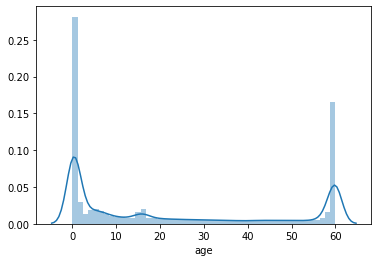

In [17]:
print('Plotting %i deaths' % len(death_data))
sns.distplot(death_data['age'])

Frequency of causes of death:

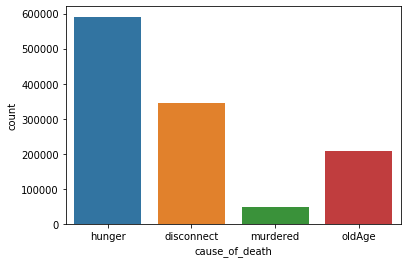

In [18]:
sns.countplot(x='cause_of_death', data=death_data)

Age by cause of death:

/Users/nvelez/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


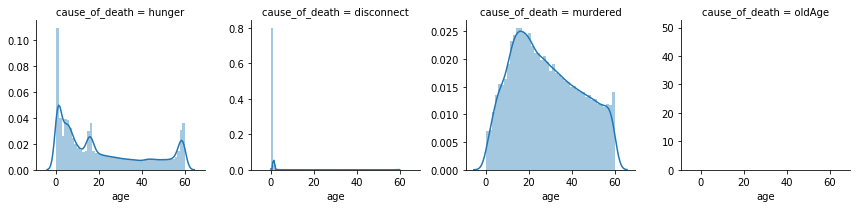

In [19]:
g = sns.FacetGrid(death_data, col='cause_of_death', sharey=False)
g.map(sns.distplot, "age")